In [1]:
import os
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem

# 你的可视化/规范化工具
from vis import visualize_and_save_frame
from render import render_html_to_image
from constrains import center_and_rescale  

def teacher_coords_from_smiles(smiles, seed=42, optimize=True):
    """
    用 RDKit ETKDG 生成 3D 坐标（仅重原子，保持与你可视化的原子顺序一致）。
    如果优化=True，做一次 UFF 优化以稳定键长。
    """
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)  # ETKDG 更稳
    params = AllChem.ETKDGv3()
    params.randomSeed = seed
    params.useSmallRingTorsions = True
    ok = AllChem.EmbedMolecule(mol, params)
    if ok != 0:
        raise RuntimeError("ETKDG embedding failed.")
    if optimize:
        try:
            AllChem.UFFOptimizeMolecule(mol, maxIters=500)
        except Exception:
            pass
    conf = mol.GetConformer()
    # 回到无氢的顺序（与你的可视化通常一致）
    mol_noH = Chem.RemoveHs(mol)
    idx_map = [conf.GetAtomPosition(a.GetIdx()) for a in mol_noH.GetAtoms()]
    Y_true = np.array([[p.x, p.y, p.z] for p in idx_map], dtype=float)
    return mol_noH, Y_true


In [2]:
from kernels import (
    KERNEL, UMAPLowKernel, GaussianKernel, StudentTKernel, pairwise_dist,
    UMAPRowExpKernel, UMAPRowFamilyKernel, SmoothKRowExpKernel, find_ab_params,
)
from kernels import KERNEL, pairwise_dist  

# 1) 选择核：低维 UMAP 核（a,b 可由 min_dist 拟合）
a,b = find_ab_params(min_dist=0.9, spread=1.0)
KERNEL = UMAPLowKernel(a, b) #UMAPLowKernel(a=a, b=b) #


def q_from_Y(Y: np.ndarray):
    D = pairwise_dist(Y)
    Q = KERNEL.forward(D)
    return Q, D
import numpy as np

_EPS = 1e-12

In [3]:


def _xlogy(x, y, eps=_EPS):
    """数值稳定版 x*log(y)，当 x==0 时返回 0，避免 0*log(0) 产生 NaN。"""
    y = np.clip(y, eps, 1 - eps)
    out = np.zeros_like(y, dtype=float)
    mask = (x != 0)
    out[mask] = x[mask] * np.log(y[mask])
    return out

def _xlog1my(x, y, eps=_EPS):
    """数值稳定版 (1-x)*log(1-y)，当 x==1 时返回 0。"""
    y = np.clip(y, eps, 1 - eps)
    out = np.zeros_like(y, dtype=float)
    mask = (x != 1)
    out[mask] = (1 - x[mask]) * np.log(1 - y[mask])
    return out

def CE(P, Y):
    """
    返回逐对 CE 矩阵（只用于监控/可视化）：
        CE_ij = - [ P_ij log Q_ij + (1-P_ij) log(1-Q_ij) ]
    —— 使用 xlogy/xlog1my 避免 0*log(0)；忽略对角项。
    """
    D = pairwise_dist(Y)
    Q = KERNEL.forward(D)
    N = Y.shape[0]
    # 忽略对角项
    eye = np.eye(N, dtype=bool)
    # 稳定计算
    CE_mat = - _xlogy(P, Q) - _xlog1my(P, Q)
    CE_mat[eye] = 0.0
    # 可选：把任何非有限数清零，确保可视化安全
    CE_mat[~np.isfinite(CE_mat)] = 0.0
    return CE_mat

def CE_gradient(P, Y):
    """
    d/dY 交叉熵的全量梯度（稳定版）：
      dL/dQ = -(P/Q) + ((1-P)/(1-Q))
      dQ/dd 由 KERNEL.dQdd 提供
      ∂d/∂y_i = (y_i - y_j)/d
    —— 关键点：
      1) Q 裁剪到 (eps,1-eps)
      2) 对角项的 dLdQ/dLdd 显式置零
      3) 任何非有限数统一置零，防止 NaN 传播
    """
    diff = Y[:, None, :] - Y[None, :, :]      # (N,N,3)
    D = pairwise_dist(Y)                       # (N,N) 含 eps
    Q = KERNEL.forward(D)                      # (N,N) 已裁剪
    N = Y.shape[0]
    eye = np.eye(N, dtype=bool)

    # dL/dQ —— 在对角上置 0，避免 inf*0 -> NaN
    Qc = np.clip(Q, _EPS, 1 - _EPS)
    dLdQ = - (P / Qc) + ((1.0 - P) / (1.0 - Qc))
    dLdQ[eye] = 0.0

    # dQ/dd
    dQdd = KERNEL.dQdd(D)
    dQdd[eye] = 0.0

    dLdd = dLdQ * dQdd
    # 非有限数清零，防止后续 *vec 扩散 NaN
    dLdd[~np.isfinite(dLdd)] = 0.0

    # ∂d/∂y_i
    vec = diff / D[:, :, None]                # (N,N,3)，对角是 0/eps ≈ 0
    vec[~np.isfinite(vec)] = 0.0

    grad = np.sum(dLdd[:, :, None] * vec, axis=1)  # (N,3)
    # 最后再护一次
    grad[~np.isfinite(grad)] = 0.0
    return grad


Cross-Entropy = 0.971707 after 0 iterations
Cross-Entropy = 0.875320 after 10 iterations
Cross-Entropy = 0.812181 after 20 iterations
Cross-Entropy = 0.755820 after 30 iterations
Cross-Entropy = 0.712554 after 40 iterations
Cross-Entropy = 0.675440 after 50 iterations
Cross-Entropy = 0.640726 after 60 iterations
Cross-Entropy = 0.607965 after 70 iterations
Cross-Entropy = 0.577111 after 80 iterations
Cross-Entropy = 0.549622 after 90 iterations
Cross-Entropy = 0.527837 after 100 iterations
Cross-Entropy = 0.512429 after 110 iterations
Cross-Entropy = 0.501985 after 120 iterations
Cross-Entropy = 0.494546 after 130 iterations
Cross-Entropy = 0.488640 after 140 iterations
Cross-Entropy = 0.483411 after 150 iterations
Cross-Entropy = 0.478444 after 160 iterations
Cross-Entropy = 0.473585 after 170 iterations
Cross-Entropy = 0.468811 after 180 iterations
Cross-Entropy = 0.464150 after 190 iterations
Cross-Entropy = 0.459641 after 200 iterations
Cross-Entropy = 0.455353 after 210 iterations

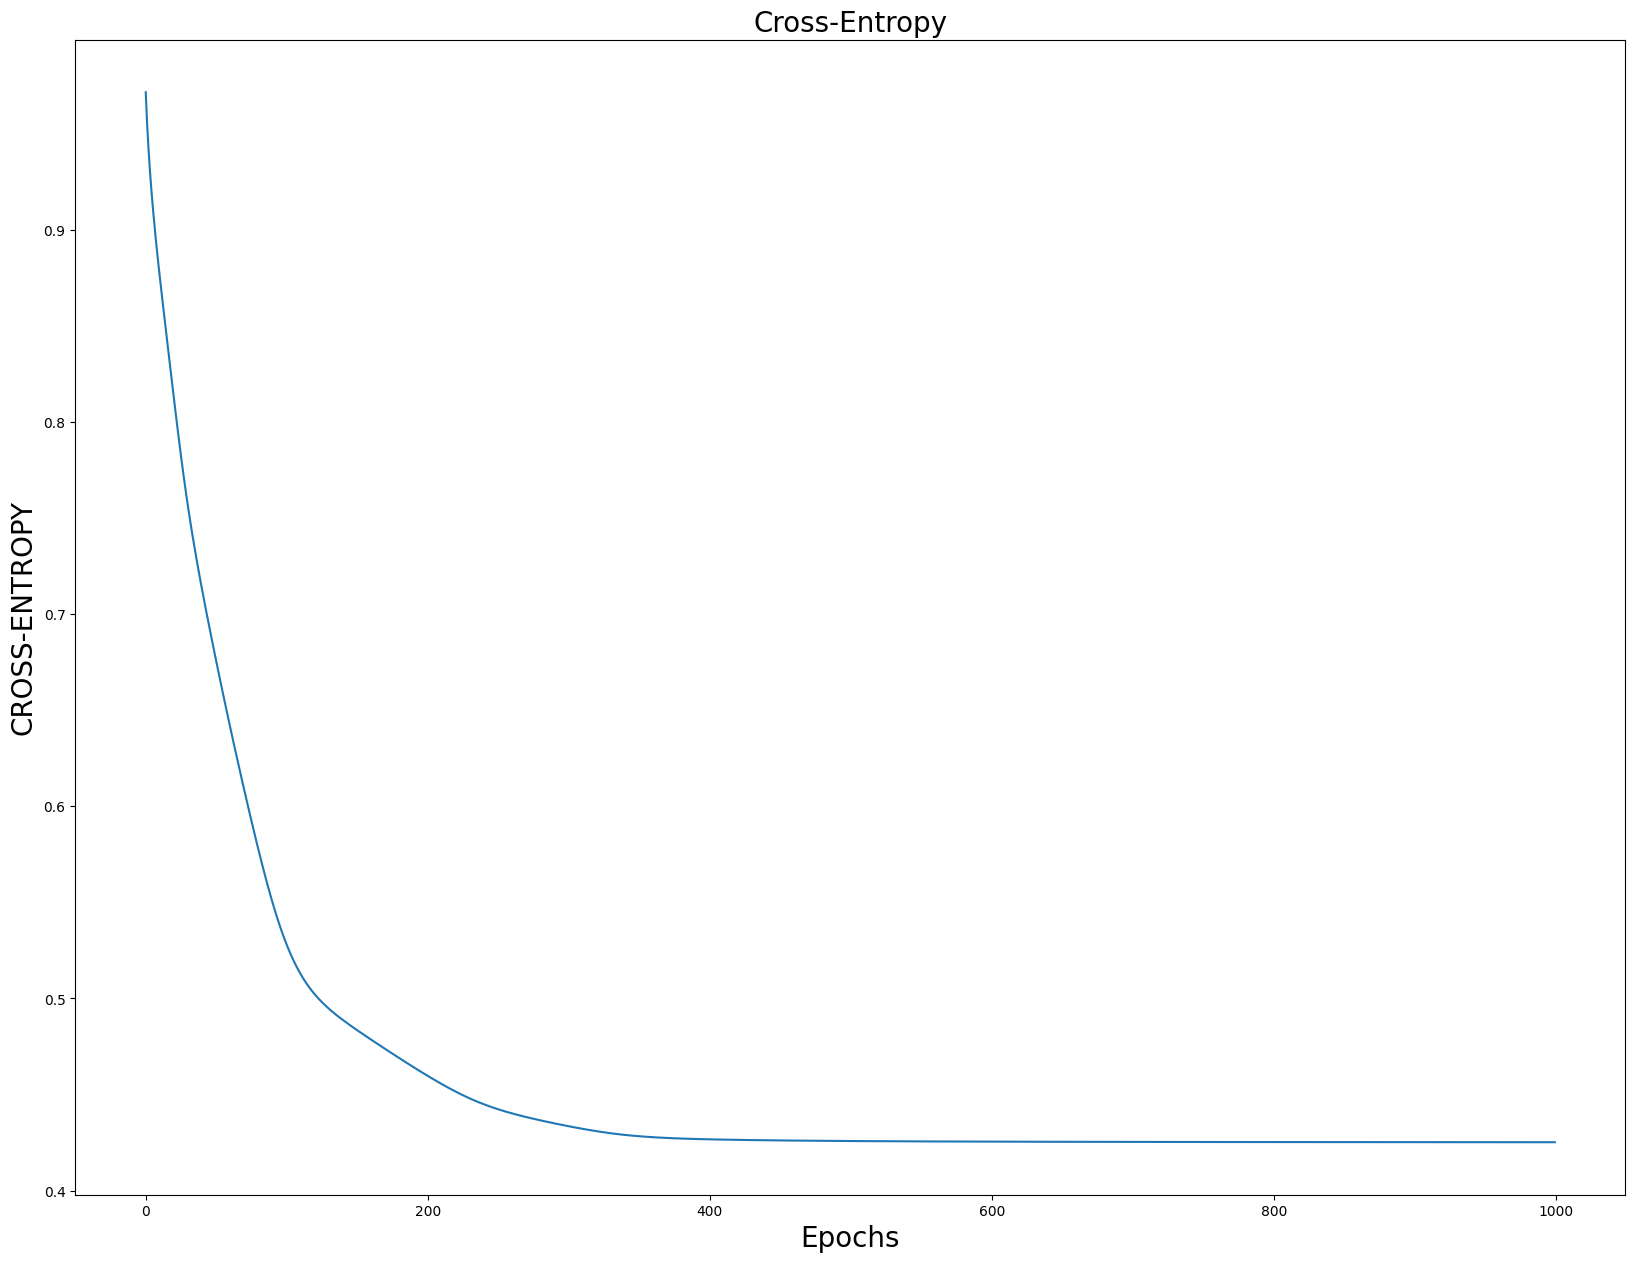

Kabsch RMSD to teacher: 0.2975


In [4]:
from matplotlib import pyplot as plt

smiles = "CC(C)(C)NCC(O)C1=CC(CO)=C(O)C=C1"

# 生成老师坐标 & 老师图（用相同核）
mol, Y_true = teacher_coords_from_smiles(smiles, seed=2025, optimize=True)
Y_true = center_and_rescale(Y_true, target_rms=1.0)
P, _ = q_from_Y(Y_true)   # 这里把“高维 Q*”记为 P（与你原代码接口一致）

# 初始化 Y（随机）并规范化
N = Y_true.shape[0]
rng = np.random.default_rng(123)
Y = rng.normal(size=(N, 3))
Y = center_and_rescale(Y, target_rms=1.0)

# 优化配置
lr = 0.01
epochs = 1000

output_dir = "frames"
os.makedirs(output_dir, exist_ok=True)

CE_array = []
for i in range(epochs):
    # 梯度 & 更新
    g = CE_gradient(P, Y)
    Y = Y - lr * g
    Y = center_and_rescale(Y, target_rms=1.0)

    # 记录 CE（用 off-diagonal 的均值）
    CE_mat = CE(P, Y)
    off = ~np.eye(N, dtype=bool)
    CE_current = CE_mat[off].mean()
    CE_array.append(CE_current)

    # 每 10 轮存一帧
    if i % 10 == 0:
        print(f"Cross-Entropy = {CE_current:.6f} after {i} iterations")
        frame_path = os.path.join(output_dir, f"frame_{i:04d}")
        visualize_and_save_frame(smiles, Y, frame_path)
        render_html_to_image(frame_path + ".html", frame_path + ".png")

# 画 CE 曲线
plt.figure(figsize=(20, 15))
plt.plot(CE_array)
plt.title("Cross-Entropy", fontsize=20)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("CROSS-ENTROPY", fontsize=20)
plt.show()

# （可选）报告与老师的 Kabsch RMSD（仅供 sanity check）
def kabsch_rmsd(Y, Yref):
    # 居中
    Yc = Y - Y.mean(0, keepdims=True)
    Zc = Yref - Yref.mean(0, keepdims=True)
    C = Zc.T @ Yc
    U, S, Vt = np.linalg.svd(C)
    R = U @ Vt
    Y_rot = Yc @ R.T
    return np.sqrt(((Y_rot - Zc)**2).mean())
rmsd = kabsch_rmsd(Y, Y_true)
print(f"Kabsch RMSD to teacher: {rmsd:.4f}")


In [5]:
from vis import visualize_molecule_with_coords
visualize_molecule_with_coords(smiles, Y)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [6]:
from vis import make_video_from_frames
make_video_from_frames("frames", "optimization.mp4", fps=5)

In [7]:
from IPython.display import Video
# 直接播放当前目录下的视频
Video("optimization.mp4", embed=True, width=600, height=400)

In [13]:
from moviepy.editor import VideoFileClip
from PIL import Image

# 修复 ANTIALIAS 的兼容性
if not hasattr(Image, 'ANTIALIAS'):
    Image.ANTIALIAS = Image.Resampling.LANCZOS

# 转换视频
clip = VideoFileClip("optimization.mp4")#.subclip(0, 5)  # 裁剪前5秒
clip = clip.resize(height=300)  # 缩小尺寸
clip.write_gif("optimization.gif", fps=3)  # 保存为GIF


MoviePy - Building file optimization.gif with imageio.
